In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
ROAD_TRANSFORM_OUTPUT_PATH = 'road_transform_output.csv'
DATA_NAME = '서해시점(E)_가로등기준_차량별_vsl_231106_074901'
DATA_OUTPUT_PATH = f'{DATA_NAME}.csv'
HISTOGRAM_IMAGE_PATH = f'{DATA_NAME}_히스토그램.png'

### Perspective Trasform 데이터 불러오기

In [125]:
df = pd.read_csv(ROAD_TRANSFORM_OUTPUT_PATH)
df

,id,frame,class,x,y,pos_x,pos_y
0,1,15,car,336.0,272.0,25.983751,1.592853
1,1,16,car,333.0,271.0,25.319107,3.262263
2,1,17,car,331.0,270.0,25.066170,4.729690
3,1,18,car,328.0,268.0,24.975657,7.496633
4,1,19,car,326.0,266.0,25.313581,10.110808
...,...,...,...,...,...,...,...
64703,5566,53961,truck,270.0,250.8,8.912163,42.483480
64704,5566,53962,truck,269.0,249.2,9.302407,45.083020
64705,5566,53963,truck,268.0,247.6,9.692653,47.682556
64706,5566,53964,truck,267.0,246.0,10.082897,50.282093


### 실제 속도로 변환하기

- 차량이 ROI 안에서 첫 번째로 인식된 그 위치와 마지막으로 인식된 그 위치를 이용하여 속도를 계산한다.
- **상수 설정**
    - `FPS`: 영상의 프레임 수, 이를 통해 단위 프레임을 단위 시간으로 변환할 수 있다.
    - `LENGTH_PIXEL`: 구간의 픽셀 단위의 길이
    - `LENGTH_METER`: 구간의 미터 단위의 길이

In [126]:
FPS = 30
LENGTH_METER = 50
LENGTH_PIXEL = 300

In [127]:
# group and aggregate min, max for caculating delta
df_delta = df[['id', 'frame', 'pos_y']].groupby('id').agg(['max', 'min'])

# calculate delta time
df_delta['delta_frame'] = df_delta['frame']['max'] - df_delta['frame']['min']
df_delta['delta_time(s)'] =  df_delta['delta_frame'] / FPS

# calculate delta distance
df_delta['delta_pos_y'] = df_delta['pos_y']['max'] - df_delta['pos_y']['min']
df_delta['delta_dis_y(m)'] = df_delta['delta_pos_y'] * LENGTH_METER / LENGTH_PIXEL

# calculate speed
df_delta['speed(km/h)'] = df_delta['delta_dis_y(m)'] / df_delta['delta_time(s)'] * 3.6 # km/h
df_delta

frame              pos_y            delta_frame delta_time(s)  \
        max    min         max        min                             
id                                                                    
1       170     15  256.906520   1.592853         155      5.166667   
4        80     66   37.041560   2.197925          14      0.466667   
6        69     61   29.057337   5.423993           8      0.266667   
12      370    357   44.734097   6.385138          13      0.433333   
14      216    189   48.584300   2.224815          27      0.900000   
...     ...    ...         ...        ...         ...           ...   
5550  53942  53942    1.868361   1.868361           0      0.000000   
5552  53974  53938   93.422730   1.808452          36      1.200000   
5560  54075  54002  147.822430   0.269232          73      2.433333   
5565  54075  54000  181.395360   1.405511          75      2.500000   
5566  53965  53957   53.730020  35.450336           8      0.266667   

     delta_pos_y delta_dis_y(m) speed(km/h)  
                                             
id                                           
1     255.313668      42.552278   29.649329  
4      34.843635       5.807272   44.798959  
6      23.633344       3.938891   53.175024  
12     38.348959       6.391493   53.098559  
14     46.359485       7.726581   30.906323  
...          ...            ...         ...  
5550    0.000000       0.000000         NaN  
5552   91.614278      15.269046   45.807139  
5560  147.553198      24.592200   36.382980  
5565  179.989849      29.998308   43.197564  
5566   18.279684       3.046614   41.129289  

[1270 rows x 9 columns]

In [128]:
df_delta.columns = ["_".join(x).strip('_') for x in df_delta.columns.to_flat_index()]
df_delta.head(3)

,frame_max,frame_min,pos_y_max,pos_y_min,delta_frame,delta_time(s),delta_pos_y,delta_dis_y(m),speed(km/h)
id,,,,,,,,,
1,170,15,256.906520,1.592853,155,5.166667,255.313668,42.552278,29.649329
4,80,66,37.041560,2.197925,14,0.466667,34.843635,5.807272,44.798959
6,69,61,29.057337,5.423993,8,0.266667,23.633344,3.938891,53.175024


In [129]:
df_delta.reset_index().to_csv(DATA_OUTPUT_PATH, index=False)

### 히스토그램 그리기

In [130]:
MIN_SPEED = 0
MAX_SPEED = 200

In [131]:
# remove nan value in speed using numpy
speed = df_delta['speed(km/h)'].to_numpy()
speed = speed[~np.isnan(speed)]
print(len(speed), speed)

1224 [29.64932913 44.79895929 53.175024   ... 36.38298042 43.19756378
 41.129289  ]


In [132]:
# remove outlier
tailored_speed = speed[np.logical_and(speed >= MIN_SPEED, speed <= MAX_SPEED)]
print(len(tailored_speed), tailored_speed)

1201 [29.64932913 44.79895929 53.175024   ... 36.38298042 43.19756378
 41.129289  ]


In [133]:
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

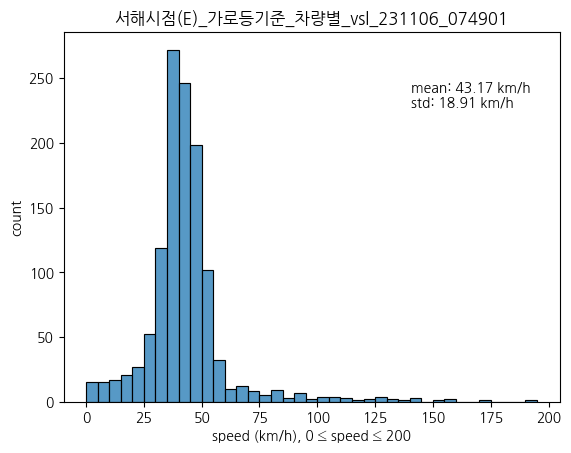

In [134]:
# set title
plt.title(DATA_NAME)

# draw speed distribution
ax = sns.histplot(data=tailored_speed, binwidth=5)
ax.set(xlabel=f'speed (km/h), {MIN_SPEED} ≤ speed ≤ {MAX_SPEED}', ylabel='count')

# draw speed mean and std text in the plot
mean = np.mean(tailored_speed)
std = np.std(tailored_speed)
ax.text(0.7, 0.8, f'mean: {mean:.2f} km/h\nstd: {std:.2f} km/h', transform=ax.transAxes)

plt.savefig(HISTOGRAM_IMAGE_PATH)
plt.show()